<a href="https://colab.research.google.com/github/muralikrishnan2022/OTDR_Fault_Analysis/blob/main/OTDR_Auto_Encoder_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import MinMaxScaler

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Step 1: Load the dataset
df = pd.read_csv('OTDR_data.csv')

# Step 2: Extract the signal points (P1 to P30) from the DataFrame
X = df[['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10',
        'P11', 'P12', 'P13', 'P14', 'P15', 'P16', 'P17', 'P18', 'P19',
        'P20', 'P21', 'P22', 'P23', 'P24', 'P25', 'P26', 'P27', 'P28',
        'P29', 'P30']].values  # Convert to NumPy array

# Step 3: Normalize the features to the range [0,1]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Step 4: Split the data into training (90%) and validation (30%) sets
X_train, X_val = train_test_split(X_scaled, test_size=0.3, random_state=42)

# Step 5: Print the shapes of the resulting datasets
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)


Training set shape: (88082, 30)
Validation set shape: (37750, 30)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

latent_dim = 10  # Dimensionality of the latent space

# Encoder
inputs = layers.Input(shape=(30,))  # 30 signal points as input
h = layers.Dense(64, activation='relu')(inputs)
h = layers.Dense(32, activation='relu')(h)

# Latent space (mean and variance)
z_mean = layers.Dense(latent_dim)(h)
z_log_var = layers.Dense(latent_dim)(h)

# Reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

# Decoder
decoder_h = layers.Dense(32, activation='relu')
decoder_mean = layers.Dense(30, activation='sigmoid')  # 30 outputs (reconstructed input)

h_decoded = decoder_h(z)
outputs = decoder_mean(h_decoded)

# VAE Model
vae = models.Model(inputs, outputs)

# Define a custom loss function using Keras operations
def vae_loss(inputs, outputs):
    # Reconstruction loss
    reconstruction_loss = tf.reduce_mean(tf.square(inputs - outputs))

    # KL divergence loss
    kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))

    # Total loss
    return reconstruction_loss + kl_loss

# Compile the model
vae.compile(optimizer='adam', loss=vae_loss)

# Print model summary to verify the architecture
vae.summary()


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17            │ (None, 30)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_102 (Dense)         │ (None, 64)             │          1,984 │ input_layer_17[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_103 (Dense)         │ (None, 32)             │          2,080 │ dense_102[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_104 (Dense)         │ (None, 10)             │            330 │ dense_103[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_105 (Dense)         │ (None, 10)             │            330 │ dense_103[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_17 (Lambda)        │ (None, 10)             │              0 │ dense_104[0][0],       │
│                           │                        │                │ dense_105[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_106 (Dense)         │ (None, 32)             │            352 │ lambda_17[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_107 (Dense)         │ (None, 30)             │            990 │ dense_106[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 6,066 (23.70 KB)

 Trainable params: 6,066 (23.70 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras import layers, models, backend as K
import tensorflow as tf

class VAELossLayer(layers.Layer):
    def call(self, inputs):
        x, outputs, z_mean, z_log_var = inputs

        # Reconstruction loss (MSE between input and output)
        reconstruction_loss = K.mean(K.square(x - outputs), axis=-1)

        # KL divergence loss
        kl_loss = -0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)

        # Combine the losses
        total_loss = K.mean(reconstruction_loss + kl_loss)

        # Add total_loss to the layer
        self.add_loss(total_loss)
        return outputs

# Step 6: Build the Variational Autoencoder (VAE) model
latent_dim = 10  # Dimensionality of the latent space

# Encoder
inputs = layers.Input(shape=(30,))  # 30 signal points as input
h = layers.Dense(64, activation='relu')(inputs)
h = layers.Dense(32, activation='relu')(h)

# Latent space (mean and variance)
z_mean = layers.Dense(latent_dim)(h)
z_log_var = layers.Dense(latent_dim)(h)

# Reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

# Decoder
decoder_h = layers.Dense(32, activation='relu')
decoder_mean = layers.Dense(30, activation='sigmoid')  # 30 outputs (reconstructed input)

h_decoded = decoder_h(z)
outputs = decoder_mean(h_decoded)

# VAE Model
vae = models.Model(inputs, outputs)

# Create the loss layer and add to the model
vae_outputs = VAELossLayer()([inputs, outputs, z_mean, z_log_var])

# Finalize the model
vae = models.Model(inputs, vae_outputs)

# Compile the model (no need to pass a loss function, it's inside the model now)
vae.compile(optimizer='adam')

# Print model summary to verify the architecture
vae.summary()

# Step 8: Train the model
vae.fit(X_train, X_train, epochs=50, batch_size=128, validation_data=(X_val, X_val))

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18            │ (None, 30)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_108 (Dense)         │ (None, 64)             │          1,984 │ input_layer_18[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_109 (Dense)         │ (None, 32)             │          2,080 │ dense_108[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_110 (Dense)         │ (None, 10)             │            330 │ dense_109[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_111 (Dense)         │ (None, 10)             │            330 │ dense_109[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_18 (Lambda)        │ (None, 10)             │              0 │ dense_110[0][0],       │
│                           │                        │                │ dense_111[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_112 (Dense)         │ (None, 32)             │            352 │ lambda_18[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_113 (Dense)         │ (None, 30)             │            990 │ dense_112[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vae_loss_layer_2          │ (None, 30)             │              0 │ input_layer_18[0][0],  │
│ (VAELossLayer)            │                        │                │ dense_113[0][0],       │
│                           │                        │                │ dense_110[0][0],       │
│                           │                        │                │ dense_111[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 6,066 (23.70 KB)

 Trainable params: 6,066 (23.70 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.1034 - val_loss: 0.0940
Epoch 2/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0941 - val_loss: 0.0938
Epoch 3/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0938 - val_loss: 0.0937
Epoch 4/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0939 - val_loss: 0.0936
Epoch 5/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0939 - val_loss: 0.0937
Epoch 6/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0938 - val_loss: 0.0936
Epoch 7/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0936 - val_loss: 0.0936
Epoch 8/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0938 - val_loss: 0.0936
Epoch 9/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0936 - val_loss: 0.0936
Epoch 10/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0938 - val_loss: 0.0936
Epoch 11/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0936 - val_loss: 0.0936
Epoch 12/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# Assume X_full is your complete dataset
X_full = np.random.rand(1000, 30)  # Example data with 1000 samples and 30 features

# Split the dataset into training and testing sets
X_train, X_test = train_test_split(X_full, test_size=0.2, random_state=42)

# Now, X_test is defined, and you can call vae.predict
X_pred = vae.predict(X_test)

# Compute reconstruction loss
reconstruction_loss = np.mean(np.square(X_test - X_pred), axis=1)

# Assuming `reconstruction_loss_train` is defined from training predictions
# For this example, we won't compute it; just make sure it's defined somewhere in your code
reconstruction_loss_train = np.mean(np.square(X_train - vae.predict(X_train)), axis=1)

# Define a threshold for anomaly detection (e.g., based on 95th percentile of training loss)
threshold = np.percentile(reconstruction_loss_train, 95)

# Detect anomalies
anomalies = reconstruction_loss > threshold

# Output detected anomalies
print("Number of anomalies detected:", np.sum(anomalies))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Number of anomalies detected: 12


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Load or define true labels for the test set
# These should correspond to X_test
# For example purposes, here's a placeholder (replace with your actual labels):
y_true = np.array([0 if i < 800 else 1 for i in range(1000)])  # 0 = normal, 1 = anomaly

# 2. Compute reconstruction loss
X_pred = vae.predict(X_test)
reconstruction_loss = np.mean(np.square(X_test - X_pred), axis=1)

# 3. Set your threshold (if not already defined)
threshold = np.percentile(reconstruction_loss_train, 95)

# 4. Predict anomalies
y_pred = (reconstruction_loss > threshold).astype(int)

# 5. Compute and display confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


NameError: name 'vae' is not defined

Epoch 1/50
787/787 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.1008 - val_loss: 0.0939
Epoch 2/50
787/787 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0939 - val_loss: 0.0937
Epoch 3/50
787/787 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0938 - val_loss: 0.0936
Epoch 4/50
787/787 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0940 - val_loss: 0.0936
Epoch 5/50
787/787 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0940 - val_loss: 0.0936
Epoch 6/50
787/787 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0937 - val_loss: 0.0936
Epoch 7/50
787/787 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0939 - val_loss: 0.0936
Epoch 8/50
787/787 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0937 - val_loss: 0.0936
Epoch 9/50
787/787 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0938 - val_loss: 0.0936
Epoch 10/50
787/787 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0936 - val_loss: 0.0936
Epoch 11/50
787/787 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0936 - val_loss: 0.0936
Epoch 12/50
787/787 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step

ValueError: The number of FixedLocator locations (8), usually from a call to set_ticks, does not match the number of labels (2).

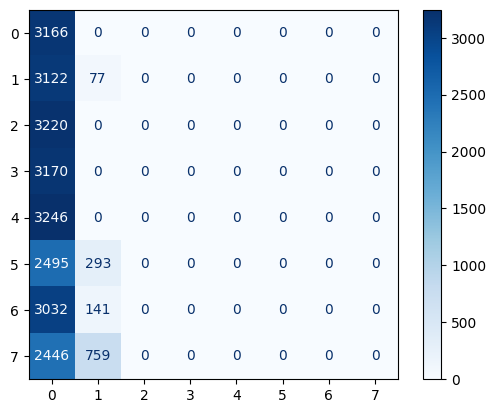

In [ ]:
# === 1. Import libraries ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# === 2. Load the dataset ===
df = pd.read_csv('/content/OTDR_data.csv')

# Extract signal points
X = df[[f'P{i}' for i in range(1, 31)]].values  # P1 to P30

# Optional: Load labels (replace 'Label' with your column name)
# Assuming 0 = normal, 1 = fault
# Load labels (0 = normal, 1 = fault)
y_full = df['Class'].values


# === 3. Normalize features ===
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# === 4. Train-test split ===
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_full, test_size=0.2, random_state=42)

# === 5. Define the VAE model ===
latent_dim = 10

# Encoder
inputs = layers.Input(shape=(30,))
h = layers.Dense(64, activation='relu')(inputs)
h = layers.Dense(32, activation='relu')(h)
z_mean = layers.Dense(latent_dim)(h)
z_log_var = layers.Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

# Decoder
decoder_h = layers.Dense(32, activation='relu')
decoder_mean = layers.Dense(30, activation='sigmoid')

h_decoded = decoder_h(z)
outputs = decoder_mean(h_decoded)

# VAE model
vae = models.Model(inputs, outputs)

# Custom loss layer
class VAELossLayer(layers.Layer):
    def call(self, inputs):
        x, outputs, z_mean, z_log_var = inputs
        reconstruction_loss = K.mean(K.square(x - outputs), axis=-1)
        kl_loss = -0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        total_loss = K.mean(reconstruction_loss + kl_loss)
        self.add_loss(total_loss)
        return outputs

vae_outputs = VAELossLayer()([inputs, outputs, z_mean, z_log_var])
vae = models.Model(inputs, vae_outputs)
vae.compile(optimizer='adam')

# === 6. Train the model ===
vae.fit(X_train, X_train, epochs=50, batch_size=128, validation_data=(X_test, X_test))

# === 7. Predict and calculate reconstruction loss ===
X_pred = vae.predict(X_test)
reconstruction_loss_test = np.mean(np.square(X_test - X_pred), axis=1)
reconstruction_loss_train = np.mean(np.square(X_train - vae.predict(X_train)), axis=1)

# Define threshold
threshold = np.percentile(reconstruction_loss_train, 95)

# Generate predicted labels: 1 = anomaly (fault), 0 = normal
y_pred = (reconstruction_loss_test > threshold).astype(int)

# === 8. Confusion matrix ===
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Fault"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# Convert multiclass labels into binary: 0 = normal, anything else = fault
y_binary = (y_test != 0).astype(int)


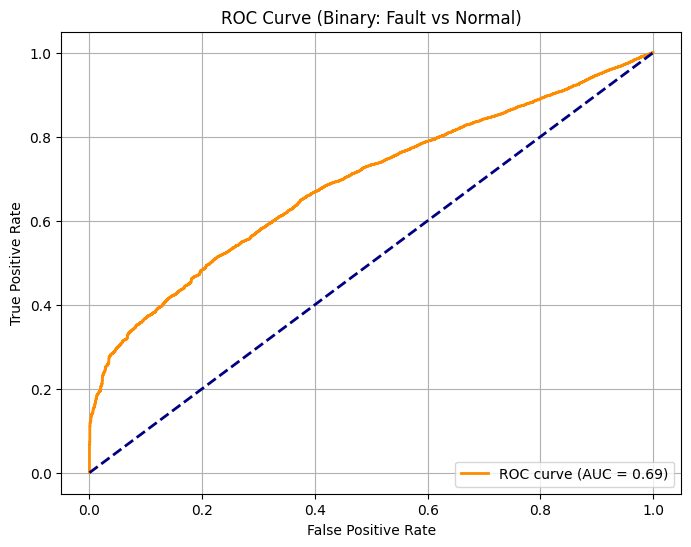

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_binary, reconstruction_loss_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Binary: Fault vs Normal)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
# Predict with VAE
X_pred = vae.predict(X_test)
reconstruction_loss_test = np.mean(np.square(X_test - X_pred), axis=1)

# Set threshold (95th percentile of training reconstruction loss)
threshold = np.percentile(reconstruction_loss_train, 95)

# Binary prediction: 1 = anomaly, 0 = normal
y_pred_binary = (reconstruction_loss_test > threshold).astype(int)

# Convert true labels to binary: 1 = fault, 0 = normal
y_binary = (y_test != 0).astype(int)


787/787 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
from sklearn.metrics import f1_score, recall_score

# Compute F1 score and recall
f1 = f1_score(y_binary, y_pred_binary)
recall = recall_score(y_binary, y_pred_binary)

print("F1 Score:", round(f1, 3))
print("Recall:", round(recall, 3))


F1 Score: 0.109
Recall: 0.058


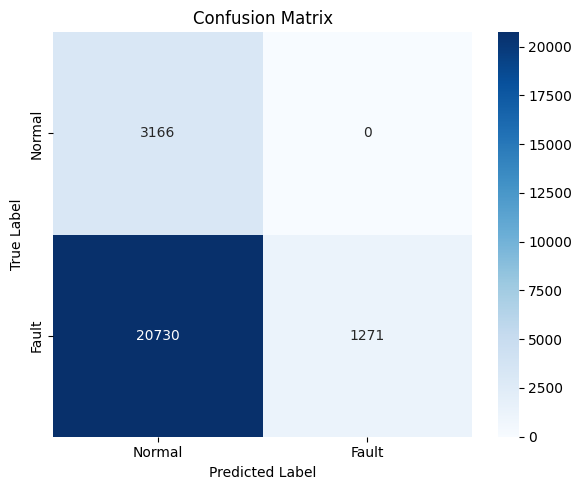

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Compute confusion matrix
cm = confusion_matrix(y_binary, y_pred_binary)
labels = ['Normal', 'Fault']

# 2. Compute F1 and Recall
f1 = f1_score(y_binary, y_pred_binary)
recall = recall_score(y_binary, y_pred_binary)

# 3. Plot confusion matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix")
plt.tight_layout()
plt.show()



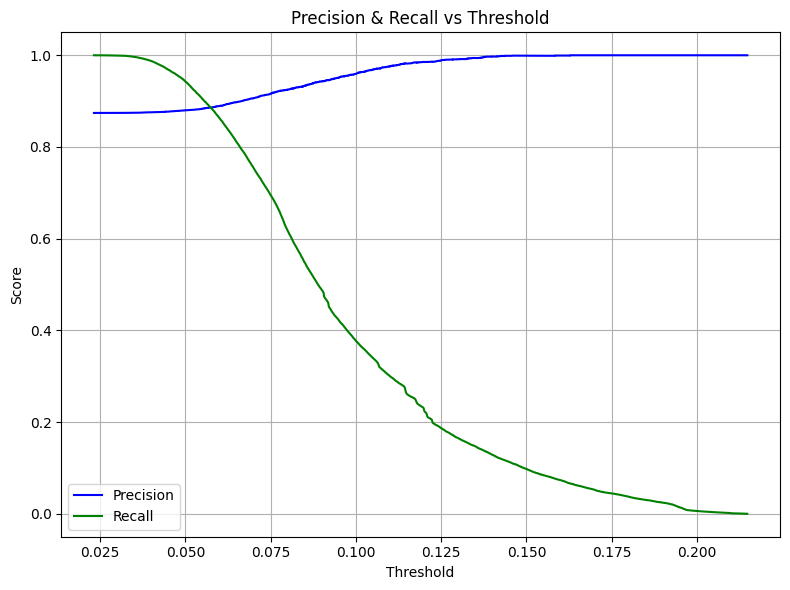

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_binary, reconstruction_loss_test)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision', color='blue')
plt.plot(thresholds, recall[:-1], label='Recall', color='green')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision & Recall vs Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
